# Final Project
## Computation and the Identification of Cultural Patterns
## Winter 2020
## _Nak Won Rim_

In [1]:
import gensim # for topic modeling
import matplotlib.pyplot as plt # for plotting
import nltk # for natural language processing
import numpy as np # for matrix calcuation
import pandas as pd # for data management
import re # for using regular expression
import seaborn as sns # for plotting
import textstat # for readability scores
from collections import defaultdict # for easier dictionary manipulation
from scipy.stats import ttest_ind # for two-sample ttests
from sklearn.model_selection import train_test_split # for random forest training
from sklearn.feature_extraction.text import TfidfVectorizer # for random forest training
from sklearn.ensemble import RandomForestClassifier # for random forest training
from sklearn.metrics import plot_confusion_matrix, roc_auc_score # for accessing random forest performance
from tabulate import tabulate # for printing tables
from textgenrnn import textgenrnn # for RNN
from datetime import datetime # for RNN
import os # for RNN

# Data

The followings are the functions I used for data cleaning and processing, but I will not run it here since it will take a lot of time. I will just import the processed data from a pickle file.

In [5]:
# these functions will not be used in this analysis
def clean_reviews(df):
    for i in range(len(df)):
        string = str(df.loc[i,"review"])
        string = string.lower()
        string.strip()
        string = re.sub("\(view spoiler\)", "", string)
        string = re.sub("\(hide spoiler\)", "", string)
        string = re.sub("http://[/\.\w\d]*", "", string)
        string = re.sub("https://[/\.\w\d]*", "", string)
        string = re.sub("[^0-9a-z \.,!?'-]", "", string)
        string = re.sub("\^", "", string)
        string = re.sub("[\[\]]", "", string)
        string = re.sub(" \.", "", string)
        string = re.sub("\.+", ".", string)
        string = re.sub(",+", ",", string)
        string = re.sub("\?+", "?", string)
        string = re.sub("-+", "-", string)
        string = re.sub("'+", "'", string)
        string = re.sub("\s+", " ", string)
        df.loc[i,"review"] = string

def drop_reviews(df):
    dropped = 0
    for i in range(len(df)):
        review = str(df.loc[i,"review"])
        if len(review) <= 250:
            df.drop(index = i, inplace=True)
            dropped += 1
    return dropped

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = stopwords.words('english') + list(string.punctuation) + ["'s", "n't"]
    tokens = [i for i in nltk.word_tokenize(text) if (i not in stop and not str(i).isdigit() and len(str(i)) > 2 )]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

# read data
final_df = pd.read_pickle('data/final.pkl')

# Are people actually writing book reviews?

In [7]:
# the lambda function will reutrn True if there were any match
final_df["review"].apply(lambda w: bool(re.search("book|read|novel|story", w))).sum() / len(final_df)

0.9669686380127763

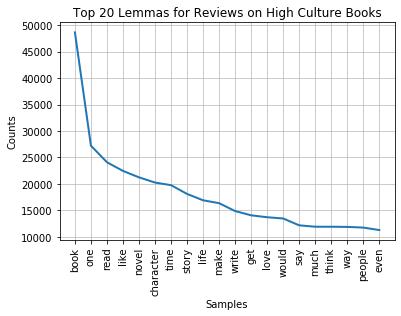

In [8]:
# join all lists of tokens to a single list of tokens and see the frequency
nltk.FreqDist([y for x in final_df[final_df['high']]['tokens'] for y in x]).plot(20, title="Top 20 Lemmas for Reviews on High Culture Books");

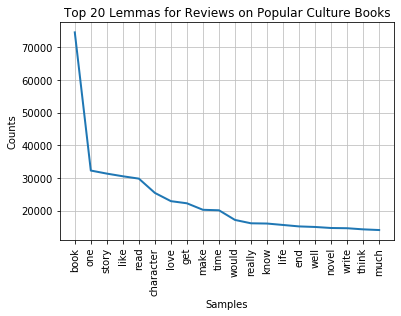

In [9]:
nltk.FreqDist([y for x in final_df[~final_df['high']]['tokens'] for y in x]).plot(20, title="Top 20 Lemmas for Reviews on Popular Culture Books");

In [10]:
# percentage of reviews that explicitly mentioned the title of the books
result = 0
for title in final_df["title"].unique():
    # split the title with "(" because the series name are included in the title inside parenthesis
    result += sum(final_df[final_df["title"] == title]["review"].apply(lambda w: title.split("(")[0].strip().lower() in w))
print(result / len(final_df))

0.345538317715405


# What Are The Difference Between The Two Categories?

## Goodreads Stats

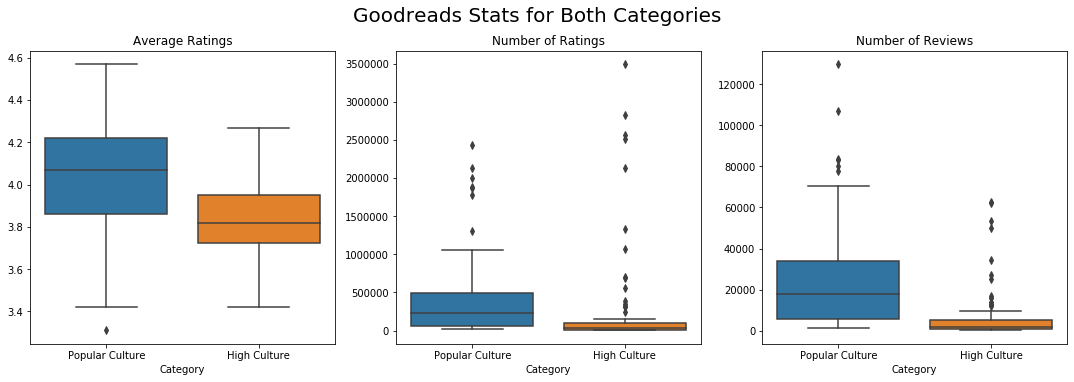

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5)) # drawing three graphs
sns.boxplot(y='avg_rating', x='high', data=book_lst, ax=ax[0])
ax[0].set_title('Average Ratings')
ax[0].set_ylabel('')
sns.boxplot(y='rating_count', x='high', data=book_lst, ax=ax[1])
ax[1].set_title('Number of Ratings')
ax[1].set_ylabel('')
sns.boxplot(y='review_count', x='high', data=book_lst, ax=ax[2])
ax[2].set_title('Number of Reviews')
ax[2].set_ylabel('')
for i in range(3):
    ax[i].set_xlabel('Category')
    ax[i].set_xticklabels(['Popular Culture', 'High Culture'])
fig.suptitle('Goodreads Stats for Both Categories', y=1.05, fontsize=20)
fig.tight_layout(pad=1.0)

In [12]:
print('Average Ratings t-test:', ttest_ind(book_lst[~book_lst['high']]['avg_rating'],
                                           book_lst[book_lst['high']]['avg_rating']))
print('Number of Ratings t-test:', ttest_ind(book_lst[~book_lst['high']]['rating_count'],
                                             book_lst[book_lst['high']]['rating_count']))
print('Number of Reviews t-test:', ttest_ind(book_lst[~book_lst['high']]['review_count'],
                                             book_lst[book_lst['high']]['review_count']))
# deleting the book lst df to free up some memory
del book_lst

Average Ratings t-test: Ttest_indResult(statistic=6.814716446755709, pvalue=1.2294498457834708e-10)
Number of Ratings t-test: Ttest_indResult(statistic=1.7327464928079588, pvalue=0.08477192559754218)
Number of Reviews t-test: Ttest_indResult(statistic=6.3890215641854775, pvalue=1.2676405740397709e-09)


## Readability Score: Are People Writing More Difficult Reviews For High Culture Books?

The reason for importing another df for the calculation is because `textstat` packages distinguish the sentence by the combination of punctuation and a capital letter. Because of this, the `string = string.lower()` line in `clean_reviews` was not applied to this dataframe. Also, I do include the code to get the readability scores, but I will not run it as it takes too much time. I will simply read the final product and plot the results.

In [14]:
funcs = [textstat.flesch_reading_ease, textstat.flesch_kincaid_grade, textstat.gunning_fog,
         textstat.automated_readability_index, textstat.coleman_liau_index, textstat.linsear_write_formula,
         textstat.dale_chall_readability_score, textstat.lexicon_count,
         lambda x: int(re.sub('[a-zA-Z]', '', (textstat.text_standard(x).split()[0])))]
names = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog',
         'automated_readability_index', 'coleman_liau_index', 'linsear_write_formula',
         'dale_chall_readability_score', 'lexicon_count', 'text_standard']
# code to get the readability metrics - takes about 30 minutes to run in my laptop
#for idx, func in enumerate(funcs):
#    textstat_df[names[idx]] = textstat_df['review'].apply(func)

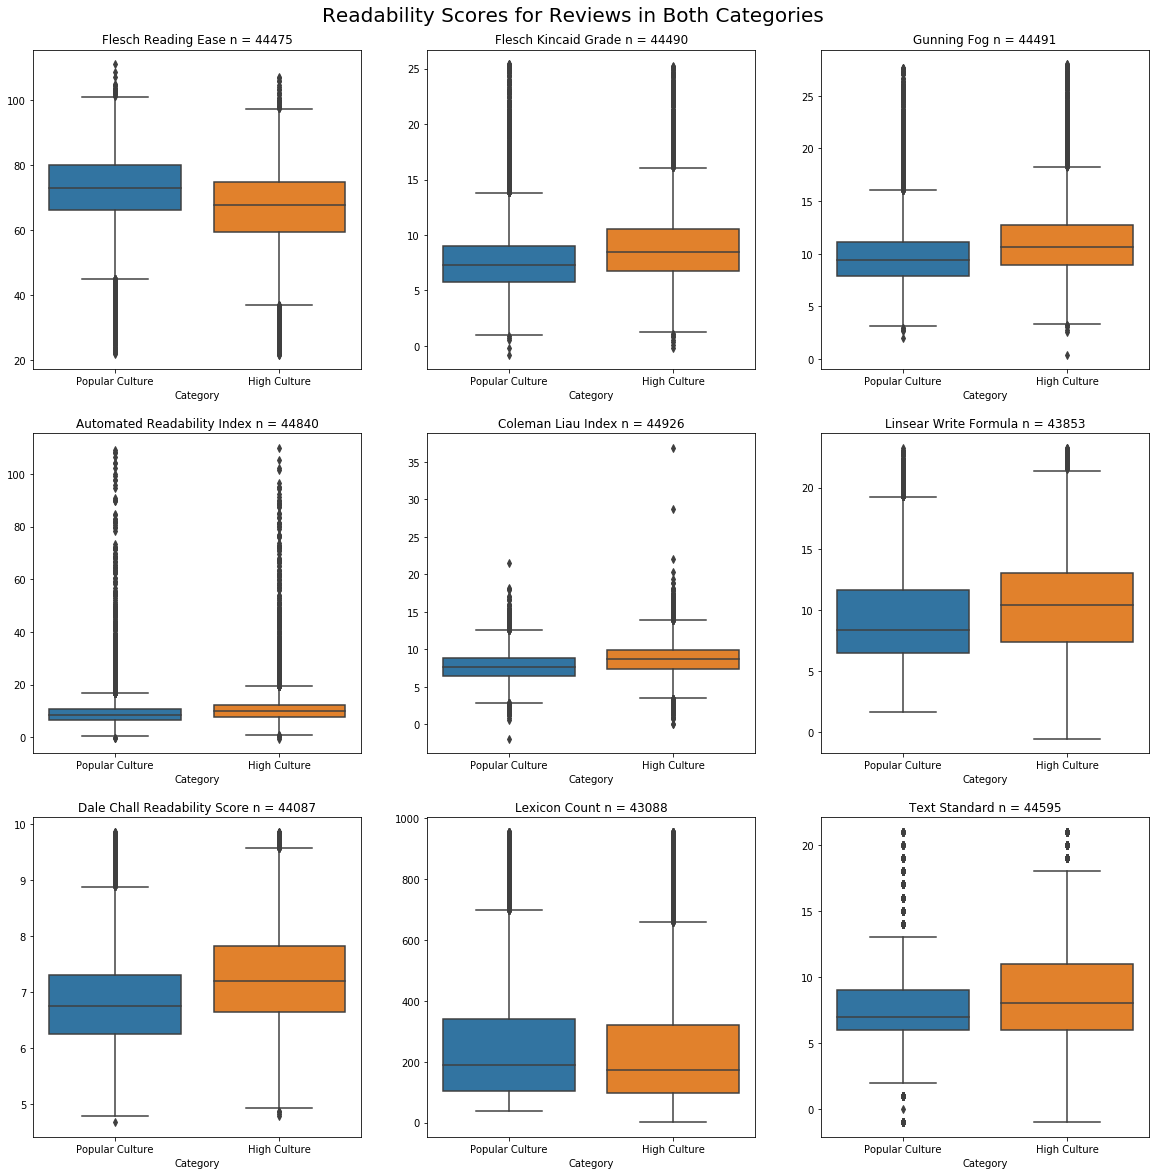

In [15]:
# reading the dataframe for textstat analysis
textstat_df = pd.read_pickle('data/textstat.pkl')

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,20)) # plotting 9 graphs
names = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog',
         'automated_readability_index', 'coleman_liau_index', 'linsear_write_formula',
         'dale_chall_readability_score', 'lexicon_count', 'text_standard']
for row in range(3):
    for col in range(3):
        i = 3 * row + col
        # calculating the mean and standard deviation and subsetting non-outlier trials
        mean = textstat_df[names[i]].mean()
        std = textstat_df[names[i]].std()
        df = textstat_df[(textstat_df[names[i]] < mean + 2 * std) &
                         (textstat_df[names[i]] > mean - 2 * std)]
        sns.boxplot(y=names[i], x='high', data=df, ax=ax[row][col])
        ax[row][col].set_title(names[i].replace('_', ' ').title() + " n = " + str(df.shape[0]))
        ax[row][col].set_ylabel('')
        ax[row][col].set_xlabel('Category')
        ax[row][col].set_xticklabels(['Popular Culture', 'High Culture'])
fig.suptitle('Readability Scores for Reviews in Both Categories', y=0.91, fontsize=20);

In [16]:
for name in names:
    # do not run t-test on lexicon count
    if name == 'lexicon_count':
        continue
    # calculating the mean and standard deviation and subsetting non-outlier trials
    mean = textstat_df[name].mean()
    std = textstat_df[name].std()
    df = textstat_df[(textstat_df[name] < mean + 2 * std) &
                     (textstat_df[name] > mean - 2 * std)]
    print('t-test on', name, ':', ttest_ind(df[df['high']][name], df[~df['high']][name]))

t-test on flesch_reading_ease : Ttest_indResult(statistic=-53.49004022392251, pvalue=0.0)
t-test on flesch_kincaid_grade : Ttest_indResult(statistic=45.65761940332287, pvalue=0.0)
t-test on gunning_fog : Ttest_indResult(statistic=47.54163767655486, pvalue=0.0)
t-test on automated_readability_index : Ttest_indResult(statistic=29.78032109842365, pvalue=5.379647037241046e-193)
t-test on coleman_liau_index : Ttest_indResult(statistic=51.75746731066986, pvalue=0.0)
t-test on linsear_write_formula : Ttest_indResult(statistic=35.64113184797579, pvalue=2.7265233240922526e-274)
t-test on dale_chall_readability_score : Ttest_indResult(statistic=54.48857451406995, pvalue=0.0)
t-test on text_standard : Ttest_indResult(statistic=45.42716094933388, pvalue=0.0)


In [17]:
# note that the df variable holds the result for text_standard outlier treatment 
# because last element of names was text_standard
print('The mean of `text_standard` for high culture book:', df[df['high']]['text_standard'].mean())
print('The mean of `text_standard` for popular culture book:', df[~df['high']]['text_standard'].mean())
# deleting the dataframes to free up some memory
del textstat_df
del df

The mean of `text_standard` for high culture book: 8.613027183452726
The mean of `text_standard` for popular culture book: 7.363454669161422


## Novels versus Books: Are people using more specific terms when reviewing high culture books?

In [18]:
# building a new dataframe since we are averaging across books
df = pd.DataFrame()
for idx, title in enumerate(final_df['title'].unique()):
    tmp = final_df[final_df['title'] == title].reset_index(drop=True)
    df.loc[idx, 'title'] = title
    df.loc[idx, 'novel_proportion'] = sum(tmp['review'].apply(lambda w: 'novel' in w)) / tmp.shape[0]
    df.loc[idx, 'book_proportion'] = sum(tmp['review'].apply(lambda w: 'book' in w)) / tmp.shape[0]
    df.loc[idx, 'high'] = tmp['high'][0]

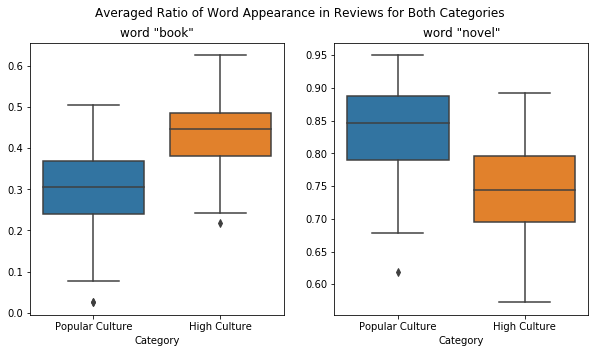

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(x='high', y='novel_proportion', data=df, ax=ax[0])
ax[0].set_title('word "book"')
ax[0].set_ylabel('')
sns.boxplot(x='high', y='book_proportion', data=df, ax=ax[1])
ax[1].set_title('word "novel"')
ax[1].set_ylabel('')
for i in range(2):
    ax[i].set_xlabel('Category')
    ax[i].set_xticklabels(['Popular Culture', 'High Culture'])
fig.suptitle('Averaged Ratio of Word Appearance in Reviews for Both Categories');

In [20]:
print('t-test on book mentioning ratio', ttest_ind(df[df['high']]['book_proportion'],
                                                   df[~df['high']]['book_proportion']))
print('t-test on novel mentioning ratio', ttest_ind(df[df['high']]['novel_proportion'],
                                                    df[~df['high']]['novel_proportion']))

t-test on book mentioning ratio Ttest_indResult(statistic=-8.474652194008092, pvalue=6.750928353064203e-15)
t-test on novel mentioning ratio Ttest_indResult(statistic=9.953856927384757, pvalue=5.12535461996782e-19)


## Authors: Are people talking more about the transcendental figure behind the texts when reviewing high culture books?

In [21]:
# building a new dataframe since we are averaging across books
df = pd.DataFrame()
for idx, title in enumerate(final_df['title'].unique()):
    # spliting and indexing the last element to get the last name
    tmp = final_df[final_df['title'] == title].reset_index(drop=True)
    author = tmp['author'][0].split()[-1].lower()
    # taking care of suffix ex) Kurt Vonnegut Jr.
    if author in ["jr.", "sr."]:
        author = tmp['author'][0].split()[-2].lower()
    df.loc[idx, 'title'] = title
    df.loc[idx, 'author'] = author
    df.loc[idx, 'author_proportion'] = sum(tmp['review'].apply(lambda w: author in w)) / tmp.shape[0]
    df.loc[idx, 'high'] = tmp['high'][0]
df = df[df['author'] != 'ng']

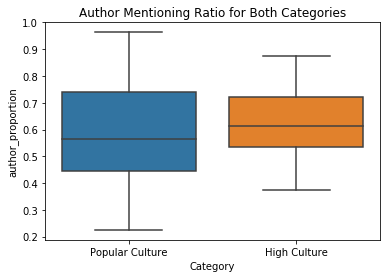

In [22]:
sns.boxplot(x='high', y='author_proportion', data=df)
plt.title('Author Mentioning Ratio for Both Categories')
plt.xlabel('Category')
plt.xticks([False, True], labels=['Popular Culture', 'High Culture']);

In [23]:
print('t-test on author mentioning ratio', ttest_ind(df[df['high']]['author_proportion'],
                                                     df[~df['high']]['author_proportion']))

t-test on author mentioning ratio Ttest_indResult(statistic=2.058700505801494, pvalue=0.04090942426678324)


## Topics: Is There a Topic That is Selectively Appearing on One Category?

In [24]:
# creating the dictionary
dictionary = gensim.corpora.Dictionary(final_df['tokens'])
# making the corpus - following two lines were executed before, but will not be run in this notebook
# corpus = [dictionary.doc2bow(text) for text in final_df['tokens']]
# gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)
reviewmm = bookmm = gensim.corpora.MmCorpus('data/corpus.mm')
# fit the model - setting seed for replication
review_lda = gensim.models.ldamodel.LdaModel(corpus=reviewmm, id2word=dictionary, num_topics=5, 
                                             alpha='auto', eta='auto', random_state=411)
# create dataframe holding the topic values as a column
lda_df = pd.DataFrame({'topics': [review_lda[dictionary.doc2bow(l)] for l in final_df['tokens']]})

# separating topic values stored in a single column to mutliple columns in a way a topic has its own column
# dictionary to temporally hold the probabilities
topics_prob_dict = {i : [0] * len(lda_df) for i in range(review_lda.num_topics)}
#Load them into the dict
for idx, topic_tuples in enumerate(lda_df['topics']):
    for topic_num, prob in topic_tuples:
        topics_prob_dict[topic_num][idx] = prob
# update the DataFrame
for topic_num in range(review_lda.num_topics):
    lda_df['topic_{}'.format(topic_num)] = topics_prob_dict[topic_num]
# drop original column since it is redundant
lda_df.drop('topics', axis=1, inplace=True)
# merging the lda_df with the final_df
lda_df = final_df.merge(lda_df, left_index=True, right_index=True)

In [25]:
# creating a dataframe that holds the average topic values for each book
# using deafultdict with default value list to use .append directly
dd = defaultdict(list)
for title in lda_df['title'].unique():
    tmp = lda_df[lda_df['title'] == title].reset_index(drop=True)
    dd['title'].append(title)
    dd['high'].append(tmp['high'][0])
    for i in range(review_lda.num_topics):
        dd['topic_{}'.format(i)].append(tmp['topic_{}'.format(i)].sum() / tmp.shape[0])
lda_book_df = pd.DataFrame(dd)

In [26]:
# plotting function
def plot_topics(high, title):
    if high:
        topic_vals = lda_book_df[lda_book_df['high']][['topic_%d' %x for x in range(review_lda.num_topics)]].values
        titles = lda_book_df[lda_book_df['high']]['title'].values
    else:
        topic_vals = lda_book_df[~lda_book_df['high']][['topic_%d' %x for x in range(review_lda.num_topics)]].values
        titles = lda_book_df[~lda_book_df['high']]['title'].values
    N = len(topic_vals)
    K = review_lda.num_topics  # N documents, K topics
    plt.figure(figsize=(20,10))
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)
    # stacking the bars
    for k in range(K):
        color = plt.cm.Set1(1)
        if k == 0:
            p = plt.bar(ind, topic_vals[:, k], width, color=plt.cm.Set1(k))
        else:
            p = plt.bar(ind, topic_vals[:, k], width, bottom=height_cumulative, color=plt.cm.Set1(k))
        height_cumulative += topic_vals[:, k]
        plots.append(p)
    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')
    plt.title(title, fontsize=20)
    plt.xticks(ind+width/2, titles, rotation='vertical')
    plt.yticks(np.linspace(0, 1, 11))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

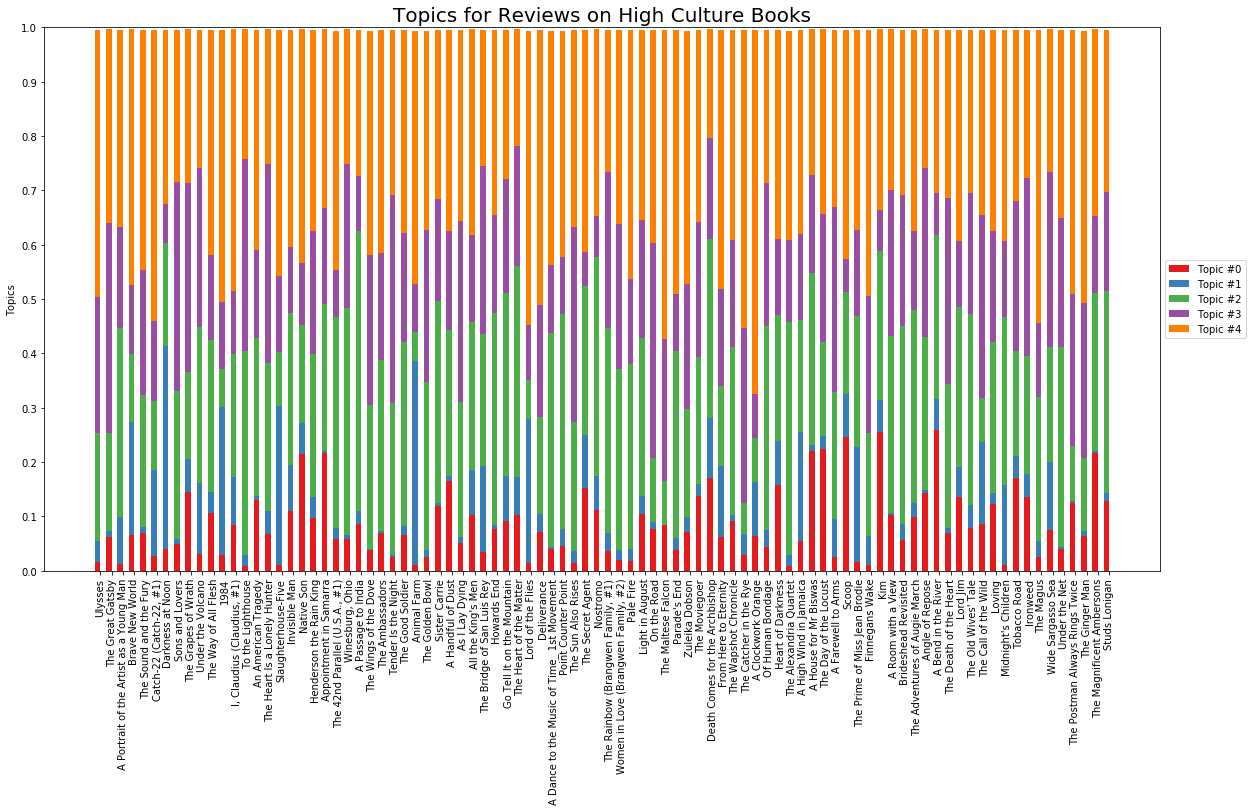

In [27]:
plot_topics(high=True, title='Topics for Reviews on High Culture Books')

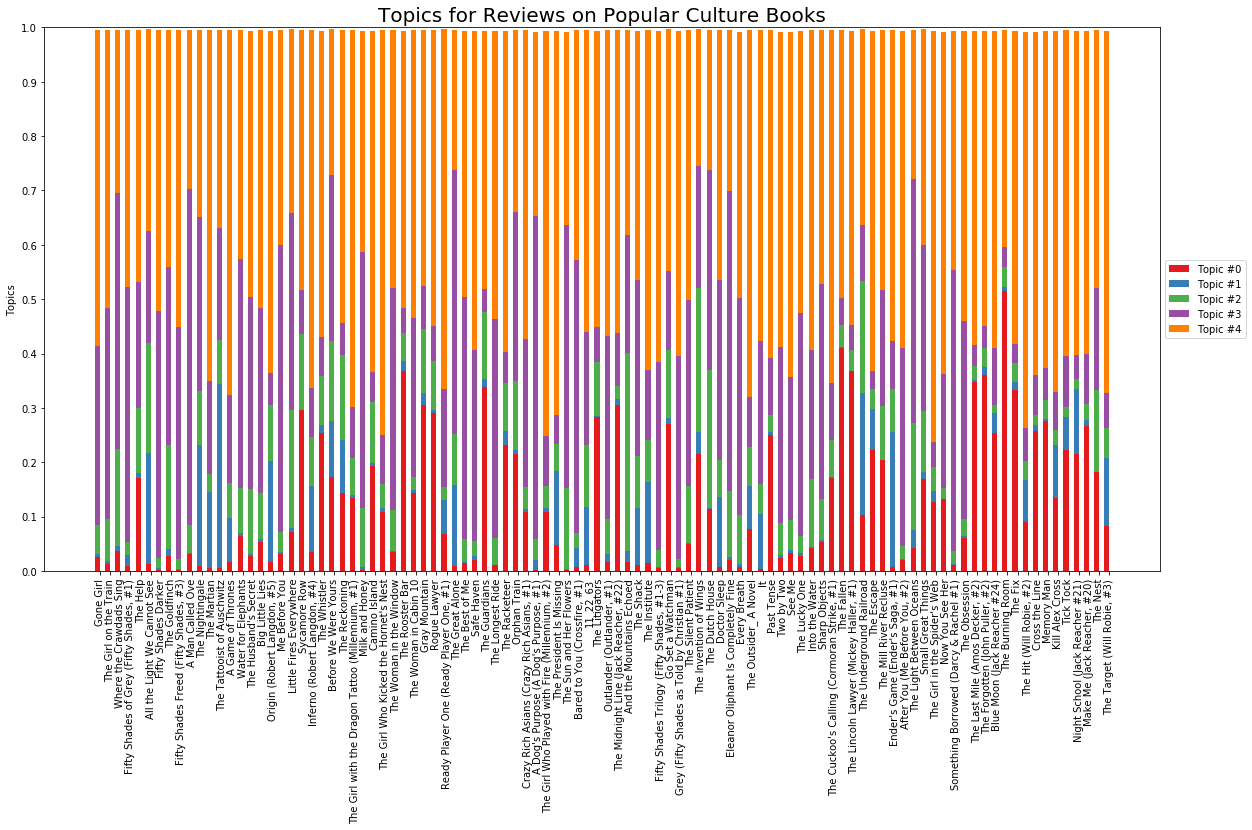

In [28]:
plot_topics(high=False, title='Topics for Reviews on Popular Culture Books')

In [29]:
print('t-test for topic #2:', ttest_ind(lda_book_df[lda_book_df['high']]['topic_2'],
                                        lda_book_df[~lda_book_df['high']]['topic_2']))
print('t-test for topic #4:', ttest_ind(lda_book_df[lda_book_df['high']]['topic_4'],
                                        lda_book_df[~lda_book_df['high']]['topic_4']))

t-test for topic #2: Ttest_indResult(statistic=15.307610781420925, pvalue=7.089592451073037e-35)
t-test for topic #4: Ttest_indResult(statistic=-8.998827837657682, pvalue=2.495324140460043e-16)


In [30]:
topics_dict = {}
for topic_num in [2, 4]:
    # getting the top topic words from lda and putting it in a dictionary
    topic_words = [w for w, p in review_lda.show_topic(topic_num, topn=10)]
    topics_dict['Topic #{}'.format(topic_num)] = topic_words
pd.DataFrame(topics_dict)

,Topic #2,Topic #4
0,novel,book
1,character,read
2,story,like
3,reader,one
4,one,story
5,book,character
6,life,get
7,write,really
8,time,reacher
9,author,time


# Black-box Models

## Using Random Forest to Classify the Reviews

In [31]:
# getting the new test set
test_df = pd.read_pickle('data/test_data.pkl')
final_df = pd.concat([final_df, test_df]).reset_index(drop=True)

# creating the tf-idf vectors
tfidfvec = TfidfVectorizer(min_df=2, stop_words='english')
final_df['tfidfvecs'] = [np.array(v).flatten() for v in tfidfvec.fit_transform(final_df['tokens'].apply(lambda x: " ".join(x))).todense()]

# splitting the test and train set
X_train, X_test, y_train, y_test = train_test_split(final_df['tfidfvecs'][:44927], final_df['high'][:44927], 
                                                    test_size=0.5, random_state=411)
X_train = np.stack(X_train, axis =0)
X_test = np.stack(X_test, axis =0)
# note that the second test set is not divided into train/test set
X_test2 = np.stack(final_df['tfidfvecs'][44927:], axis=0)
y_test2 = final_df['high'][44927:]

# fitting the random forest models
rf = RandomForestClassifier(random_state=411, n_jobs=4).fit(X_train, y_train)

# getting the prediction by model
train_predict = rf.predict(X_train)
test_predict = rf.predict(X_test)
test2_predict = rf.predict(X_test2)

In [32]:
# accuracy and auc scores
print(tabulate([['train set', sum(train_predict == y_train) / len(y_train), 
                 roc_auc_score(y_train, train_predict)],
                ['test set 1', sum(test_predict == y_test) / len(y_test), 
                 roc_auc_score(y_test, test_predict)],
                ['test set 2', sum(test2_predict == y_test2) / len(y_test2), 
                 roc_auc_score(y_test2, test2_predict)]],
               headers = ['Set', 'Accuracy', 'AUC Score']))

Set           Accuracy    AUC Score
----------  ----------  -----------
train set     1            1
test set 1    0.919293     0.917673
test set 2    0.772273     0.780368


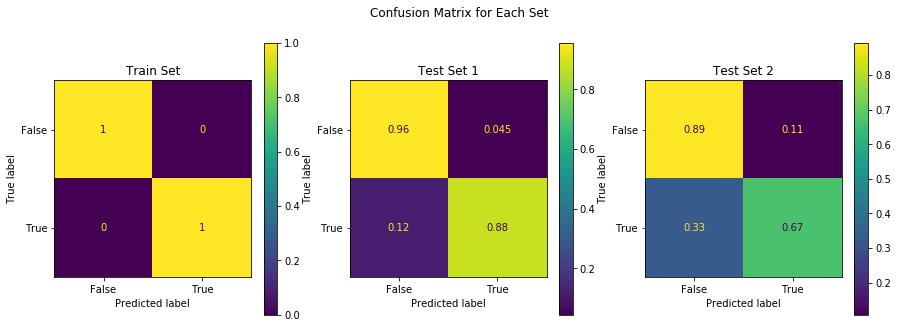

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
plot_confusion_matrix(rf, X_train, y_train, normalize='true', ax=ax[0])
ax[0].set_title('Train Set')
plot_confusion_matrix(rf, X_test, y_test, normalize='true', ax=ax[1])
ax[1].set_title('Test Set 1')
plot_confusion_matrix(rf, X_test2, y_test2, normalize='true', ax=ax[2])
ax[2].set_title('Test Set 2')
fig.suptitle('Confusion Matrix for Each Set');

## Using RNN to generate reviews-like texts

Note that I ran this in a Google Colab Notebook, so the results are not printed here.

In [ ]:
all_df = pd.read_pickle('Data/tokenized.pkl')
with open('high_rnn.txt', 'w') as f:
    for txt in all_df[all_df['high']]['review']:
        f.write(txt + '\n')
with open('popular_rnn.txt', 'w') as f:
    for txt in all_df[~all_df['high']]['review']:
        f.write(txt + '\n')

file_name = "high_rnn.txt"
model_name = "high_generator" 

model_cfg = {
    'word_level': False,   # set to True if want to train a word-level model (requires more data and smaller max_length)
    'rnn_size': 128,   # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 3,   # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': False,   # consider text both forwards and backward, can give a training boost
    'max_length': 30,   # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
    'max_words': 10000,   # maximum number of words to model; the rest will be ignored (word-level model only)
}

train_cfg = {
    'line_delimited':True,   # set to True if each text has its own line in the source file
    'num_epochs': 10,   # set higher to train the model for longer
    'gen_epochs': 2,   # generates sample text from model after given number of epochs
    'train_size': 0.8,   # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'dropout': 0.0,   # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'validation': False,   # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'is_csv': False   # set to True if file is a CSV exported from Excel/BigQuery/pandas
}

textgen = textgenrnn(name=model_name)

train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file

train_function(
    file_path=file_name,
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=1024,
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=100,
    word_level=model_cfg['word_level'])

textgen.generate_samples(n=1, temperatures=[0.2, 0.5, 1.0])